In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import os
from pathlib import Path
import numpy as np

In [2]:
data_dir = "./Dataset/All"
class_names = os.listdir(data_dir)
data_path = Path(data_dir)

images_dict = {}
images_labels = {}

count = 0
for class_name in class_names:
    images_dict[class_name] = list(data_path.glob(f"{class_name}/*"))
    images_labels[class_name] = count
    count = count + 1

X, y = [], []

In [3]:

# Load data from 'images_dict_all'
for class_name, images in images_dict.items():
    for image in images:
        image_array = cv2.imread(str(image))
        
        # Check if image is successfully read
        if image_array is not None:
            resized_img = cv2.resize(image_array, (176, 176))
            X.append(resized_img)
            y.append(images_labels[class_name])
        else:
            print(f"Warning: Unable to read image - {image}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)



In [4]:
#Load data Contd..
labels = dict(zip([0,1,2,3], class_names))
labels

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

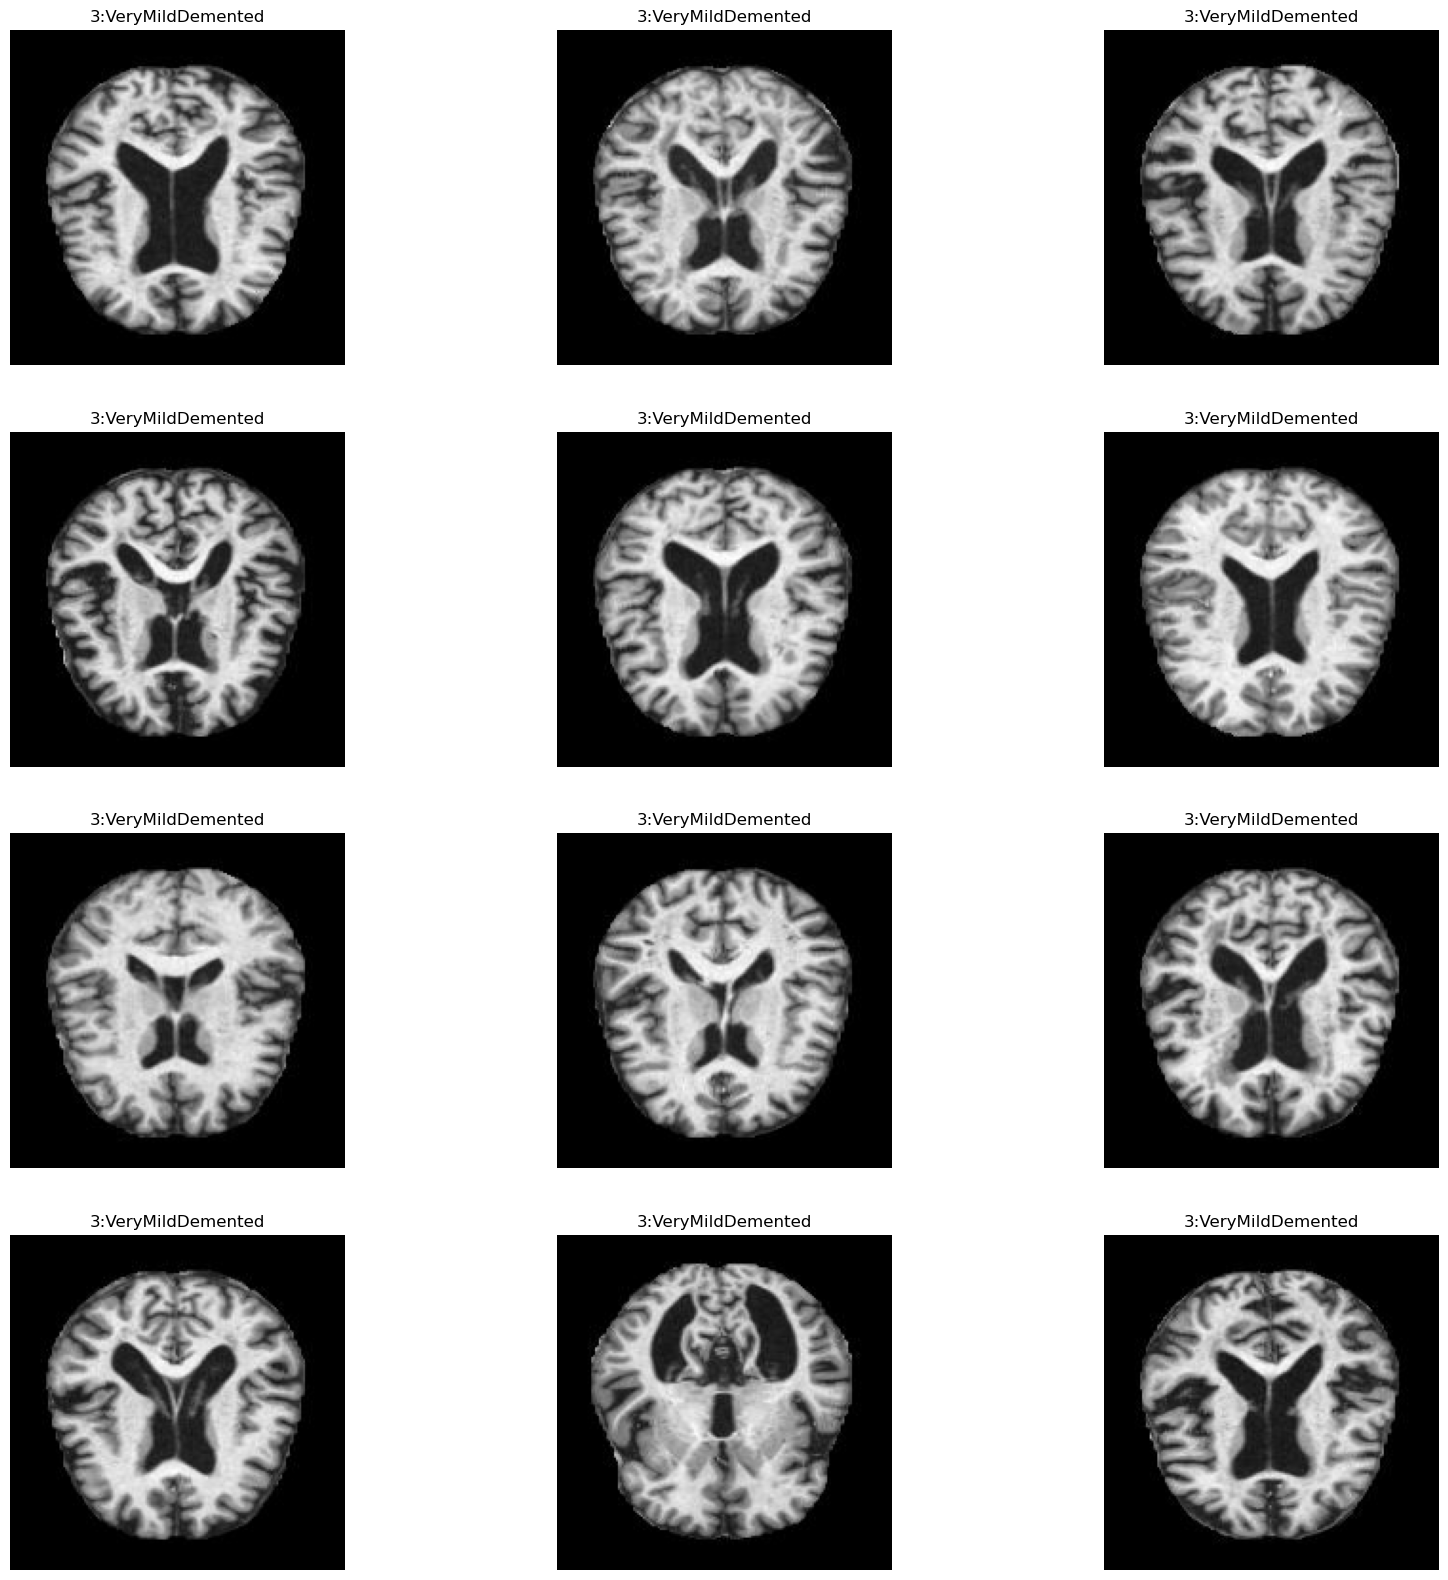

In [5]:
#Showing images
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))

for i in range(5000, 5012):
    plt.subplot(int(12/3), 3, i - 4999)
    plt.axis("off")
    plt.imshow(X[i])
    plt.title(f"{y[i]}:{labels[y[i]]}")

plt.show()

In [6]:
#Balancing for minority classes by oversampling

from imblearn.over_sampling import SMOTE

overSampler = SMOTE()

X_resampled, y_resampled = overSampler.fit_resample(X.reshape(-1, 176 * 176 * 3), y)


X_resampled = X_resampled.reshape(-1, 176, 176, 3)

unique_classes, counts = np.unique(y_resampled, return_counts=True)

print("Class Counts:")
for class_label, count in zip(unique_classes, counts):
    print(f"Class {class_label}: {count} instances")

Class Counts:
Class 0: 3200 instances
Class 1: 3200 instances
Class 2: 3200 instances
Class 3: 3200 instances


In [7]:
from sklearn.model_selection import train_test_split as tts
seed_value = 42
X_train, X_test, y_train, y_test = tts(X_resampled, y_resampled, test_size=0.2, random_state=seed_value)

In [8]:
X_train.shape

(10240, 176, 176, 3)

In [9]:
y_train.shape

(10240,)

In [10]:
#Bringing pixel values b/w 0 and 1 by new_val = curr_val/max(total_matrix)

#X_val = X_val/255

In [11]:
!pip install "tensorflow-addons<2.11"

In [12]:
import tensorflow as tf
import tensorflow_addons.metrics as F1Score
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Recall, Precision
import keras_tuner as kt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, RandomBrightness, GlobalAveragePooling2D, Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
tf.compat.v1.disable_eager_execution()

with tf.compat.v1.Session():
    dst_tensor = tf.zeros(shape=(10, 10), dtype=tf.float32)

C:\Users\hp\.conda\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\hp\.conda\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to ma

In [13]:

seed_value = 42
num_classes = len(labels)


# Function to create a data augmentation sequence
def create_data_augmentation():
    return Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical", seed=seed_value),
        RandomRotation(0.1, seed=seed_value),
        RandomBrightness(0.2, seed=seed_value),
        RandomContrast(0.2, seed=seed_value),
    ])



#initial_lr = 0.001

#def lr_schedule(epoch):
#   return initial_lr * 0.9 ** epoch

#lr_scheduler = LearningRateScheduler(lr_schedule)

def model_builder(hp):
      
    model = Sequential([
        Input(shape=(176, 176,3)),
        create_data_augmentation(),  
        
    ])
    
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_conv_layers):
        hp_filters = hp.Int(f'filters_{i}', min_value=16, max_value=64, step=2)
        hp_kernel_size = hp.Int(f'kernel_size_{i}', min_value=3, max_value=5, step=1)
        cnn_layer = Conv2D(filters=hp_filters, kernel_size=(hp_kernel_size, hp_kernel_size), padding='same', activation='relu')
        pool_layer = MaxPooling2D()
        model.add(cnn_layer)
        model.add(pool_layer)

    model.add(Flatten())
    
    for i in range(num_dense_layers):
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=2)
        hidden_layer = Dense(units=hp_units, activation='relu')
        b_norm = BatchNormalization()
        hp_dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.05)
        dout = Dropout(hp_dropout_rate)
        model.add(hidden_layer)
        model.add(b_norm)
        model.add(dout)

    
    output_layer = Dense(num_classes, activation='softmax')

    model.add(output_layer)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    
    return model




with tf.device('/GPU:0'):
    tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='./',
                     project_name='Tuned_AlzDis_Model')

    stop_early = EarlyStopping(monitor='val_loss', patience=5)
    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=2)[0]

    
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))

    hypermodel = tuner.hypermodel.build(best_hps)

    # Retrain the model
    history2 = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)
    
    hypermodel.summary()

"""
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
"""

Trial 26 Complete [00h 03m 10s]
val_accuracy: 0.92578125

Best val_accuracy So Far: 0.947265625
Total elapsed time: 00h 33m 24s
Train on 8192 samples, validate on 2048 samples
Epoch 1/50
8192/8192 [==============================] - 10s 1ms/sample - loss: 0.7825 - accuracy: 0.6781 - val_loss: 0.7948 - val_accuracy: 0.7109
Epoch 2/50
8192/8192 [==============================] - 10s 1ms/sample - loss: 0.2877 - accuracy: 0.8978 - val_loss: 0.5905 - val_accuracy: 0.7451
Epoch 3/50
8192/8192 [==============================] - 10s 1ms/sample - loss: 0.1204 - accuracy: 0.9670 - val_loss: 0.2561 - val_accuracy: 0.9067
Epoch 4/50
8192/8192 [==============================] - 10s 1ms/sample - loss: 0.0603 - accuracy: 0.9861 - val_loss: 0.2647 - val_accuracy: 0.9019
Epoch 5/50
8192/8192 [==============================] - 10s 1ms/sample - loss: 0.0325 - accuracy: 0.9949 - val_loss: 0.2369 - val_accuracy: 0.9155
Epoch 6/50
8192/8192 [==============================] - 10s 1ms/sample - loss: 0.0200 - a

"\n        Conv2D(32, 3, padding='same', activation='relu'),\n        MaxPooling2D(),\n        Conv2D(64, 3, padding='same', activation='relu'),\n        MaxPooling2D(),\n        Flatten(),\n        Dense(512, activation='relu'),\n        BatchNormalization(),\n        Dropout(0.5),\n        Dense(128, activation='relu'),\n        BatchNormalization(),\n        Dropout(0.5),\n        Dense(num_classes, activation='softmax')\n"

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   multiple                  0         
                                                                 
 conv2d_3 (Conv2D)           (None, 176, 176, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 88, 88, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 88, 88, 22)        8822      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 44, 44, 22)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 42592)            

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
test_loss_hyper, test_accuracy_hyper = model.evaluate(X_test, y_test)
print(f'Good Model Loss: {test_loss}, Good Model Accuracy: {test_accuracy}')
print(f'Hyper Model Loss: {test_loss_hyper}, Hyper Model Accuracy: {test_accuracy_hyper}')


Good Model Loss: 0.22289436791324987, Good Model Accuracy: 0.94140625
Hyper Model Loss: 0.22289436791324987, Hyper Model Accuracy: 0.94140625


****************Paint History**********************

<------------------Good Model-------------------->


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

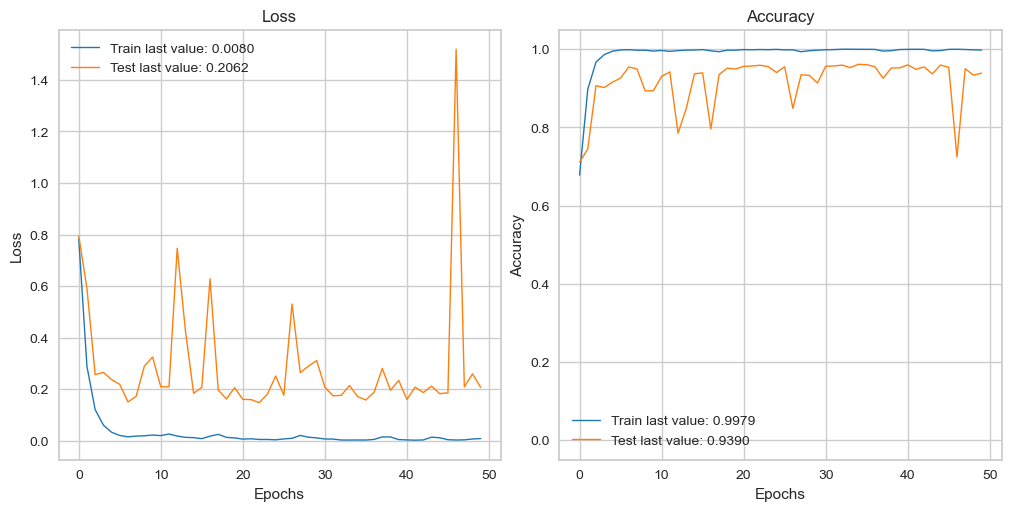

In [137]:
from plot_keras_history import show_history, plot_history
import time
print("****************Paint History**********************\n")

print("<------------------Good Model-------------------->")
plot_history(history, path="./history_of_model_hyperparameterized.png")


<------------------Hyper Model-------------------->


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

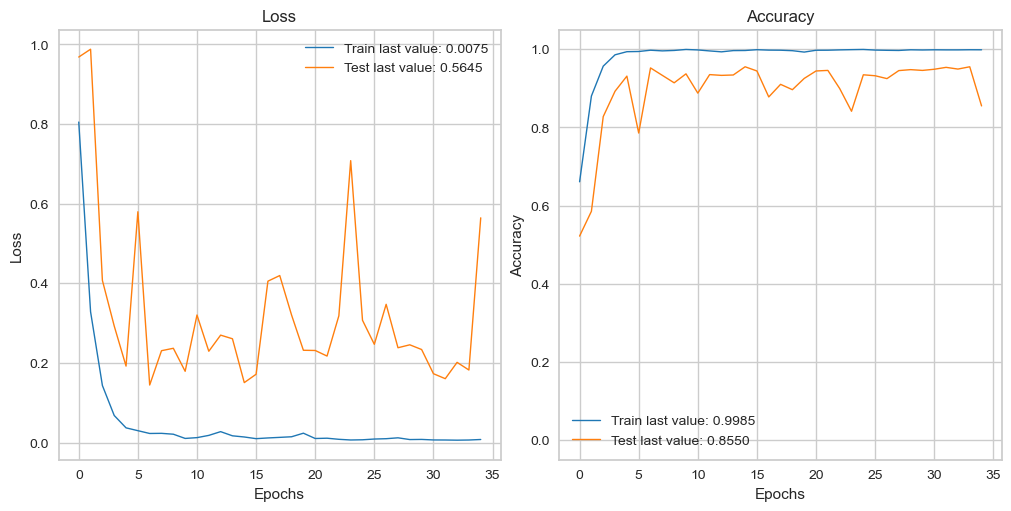

In [138]:
print("<------------------Hyper Model-------------------->")
plot_history(history2, path = "./history_of_model_hyperparameterised_reincarnated.png")


In [18]:
y_test_pred_probs = model.predict(X_test)  
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

y_test_pred_probs_hyper = hypermodel.predict(X_test)  
y_test_pred_hyper = np.argmax(y_test_pred_probs_hyper, axis=1)


print(y_test_pred)
print(y_test_pred_hyper)


C:\Users\hp\.conda\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[3 1 2 ... 1 2 0]
[3 1 2 ... 1 2 0]


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm_test = confusion_matrix(y_test, y_test_pred)
cr_test = classification_report(y_test, y_test_pred)

cm_test_hyp = confusion_matrix(y_test, y_test_pred_hyper)
cr_test_hyp = classification_report(y_test, y_test_pred_hyper)


print(f"Confusion Matrix:\nGood Model:\n{cm_test}\nHyper Model:\n{cm_test_hyp}")
print(f"Classification Report:\nGood Model:\n{cr_test}\nHyper Model:\n{cr_test_hyp}")

Confusion Matrix:
Good Model:
[[562   1   7  69]
 [  0 632   0   3]
 [  0   0 651  11]
 [ 37   1  21 565]]
Hyper Model:
[[441   7   2 189]
 [  0 635   0   0]
 [  0   0 495 167]
 [ 22   2   0 600]]
Classification Report:
Good Model:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       639
           1       1.00      1.00      1.00       635
           2       0.96      0.98      0.97       662
           3       0.87      0.91      0.89       624

    accuracy                           0.94      2560
   macro avg       0.94      0.94      0.94      2560
weighted avg       0.94      0.94      0.94      2560

Hyper Model:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       639
           1       0.99      1.00      0.99       635
           2       1.00      0.75      0.85       662
           3       0.63      0.96      0.76       624

    accuracy                           0.85     

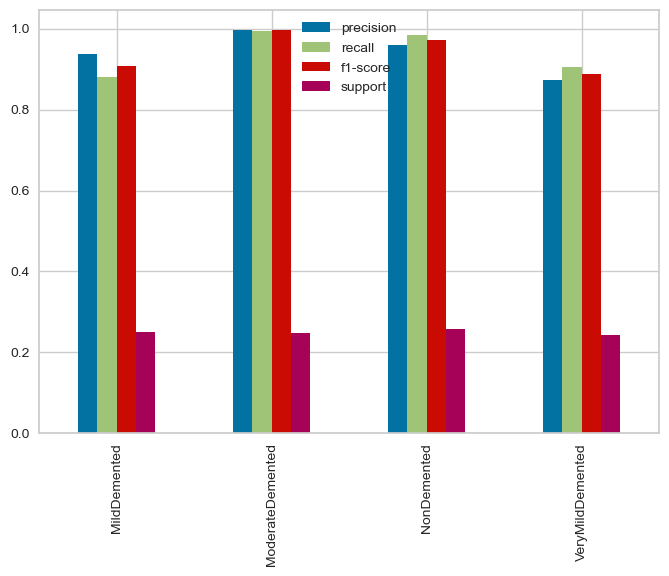

In [130]:
cr_test = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
cr_test_hyp = classification_report(y_test, y_test_pred_hyper, target_names=class_names, output_dict=True)

import pandas as pd

metrics = ['precision', 'recall', 'f1-score', 'support']

for key in ['accuracy', 'macro avg', 'weighted avg']:
    cr_test.pop(key, None)
    cr_test_hyp.pop(key, None)
index = list(cr_test.keys())


print("Good Model:")
values_by_metrics = {metric: [cr_test[class_name][metric] for class_name in index] for metric in metrics}
values_by_metrics['support'] = np.array(values_by_metrics['support'])/sum(values_by_metrics['support'])
df = pd.DataFrame(values_by_metrics, index)
ax = df.plot.bar()

Hyper Model


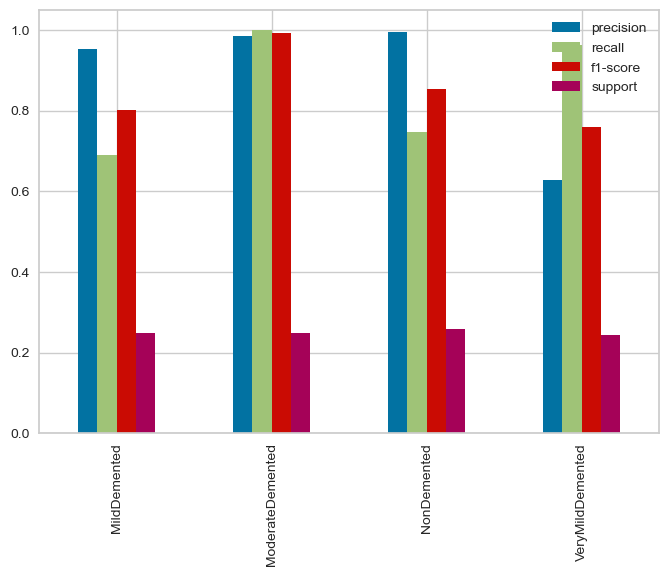

In [132]:
values_by_metrics = {metric: [cr_test_hyp[class_name][metric] for class_name in index] for metric in metrics}
values_by_metrics['support'] = np.array(values_by_metrics['support'])/sum(values_by_metrics['support'])
df = pd.DataFrame(values_by_metrics, index)
print("Hyper Model")
ax = df.plot.bar()

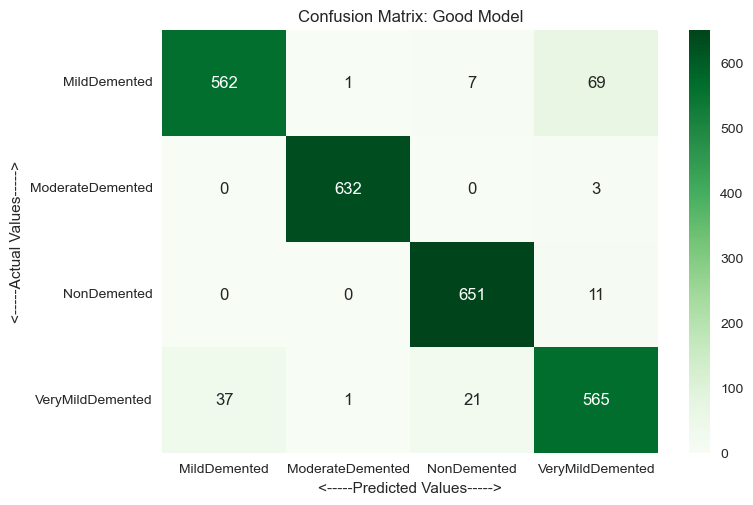

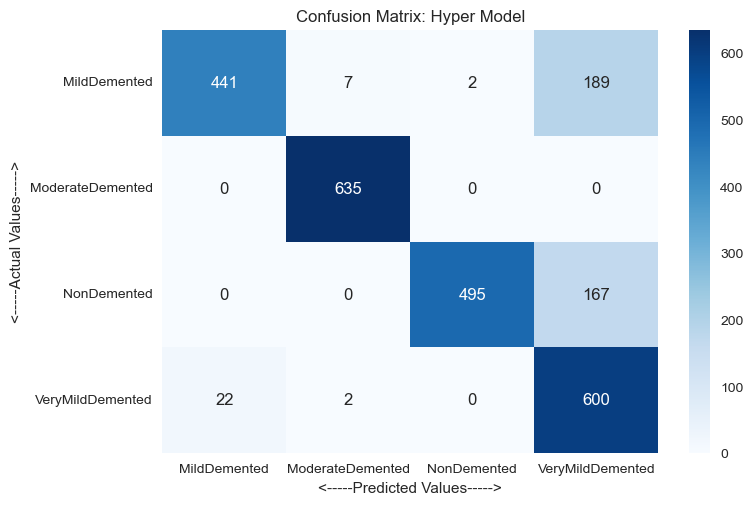

In [133]:
import seaborn as sns
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Good Model')
plt.xlabel('<-----Predicted Values----->')
plt.ylabel('<-----Actual Values----->')
plt.show()
print("\n"*2)
sns.heatmap(cm_test_hyp, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Hyper Model')
plt.xlabel('<-----Predicted Values----->')
plt.ylabel('<-----Actual Values----->')
plt.show()

In [21]:
#Simple Manual Value Checking
print(69/37)
print(189/22)

1.864864864864865
8.590909090909092


In [22]:
#In the classification report hypertuned but not reincarnated model performs better in terms of accuracy
#There is a low chance of overfitting, so the accuracy is quite acceptable
(94+85)/2

89.5

In [139]:
from joblib import dump
model.save("./AlzDisConvModel_hyperTuned.h5")
hypermodel.save("./AlzDisConvModel_hyperTuned_reincarnated.h5")
dump(overSampler, 'overSampler.joblib')


['overSampler.joblib']

In [ ]:
#After testing with other datasets or the full raw one, the model having better accuracy will be the winner here.